# Evaluation Script Test 

In [1]:
using AutomotiveDrivingModels, AutoViz, Reel

Load models and config

In [2]:
include("eval-env/occluded_crosswalk.jl") # env config

CrosswalkEnv

In [3]:
include("eval-env/constant_pedestrian.jl") # pedestrian model

In [4]:
include("eval-env/pedestrian_flow.jl")

initial_pedestrian

In [5]:
include("eval-env/simple_sensor.jl")

is_observable

In [6]:
include("eval-env/ego_control.jl")

initial_ego

In [7]:
include("simulation.jl")

In [8]:
include("eval_config.jl") # eval config

is_terminal (generic function with 1 method)

In [9]:
include("baseline_policy.jl")

update

In [10]:
include("render_helpers.jl")

## Initialize 

### Configure the Evaluation
- Time step
- Number of episodes 
- ...

In [11]:
config = EvalConfig() # use default

EvalConfig(0.1,MersenneTwister(UInt32[0x00000003],Base.dSFMT.DSFMT_state(Int32[-1359582567,1073454075,1934390716,1073583786,-114685834,1073112842,-1913218479,1073122729,-73577195,1073266439  …  1226759590,1072980451,-1366384707,1073012992,1661148031,2121090155,141576524,-658637225,382,0]),[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0  …  0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],382),1,200,(AutomotiveDrivingModels.CollisionCallback
  mem: AutomotiveDrivingModels.CPAMemory
,TerminalCallback()))

In [12]:
cam = FitToContentCamera(0.0)

AutoViz.FitToContentCamera(0.0)

### Configure the Environment

In [13]:
params = EnvParams(ped_rate = 0.5)
env = CrosswalkEnv(params)

CrosswalkEnv(Roadway,AutomotiveDrivingModels.Lane(LaneTag(1, 1),AutomotiveDrivingModels.CurvePt[CurvePt({25.000, -10.000, 1.571}, 0.000, 0.000, NaN),CurvePt({25.000, 10.000, 1.571}, 20.000, 0.000, NaN)],6.0,AutomotiveDrivingModels.SpeedLimit(-Inf,Inf),AutomotiveDrivingModels.LaneBoundary(:unknown,:unknown),AutomotiveDrivingModels.LaneBoundary(:unknown,:unknown),AutomotiveDrivingModels.LaneConnection[],AutomotiveDrivingModels.LaneConnection[]),AutomotiveDrivingModels.ConvexPolygon[ConvexPolygon: len 4 (max 4 pts)
	VecE2(15.000, -1.500)
	VecE2(15.000, -4.500)
	VecE2(22.000, -4.500)
	VecE2(22.000, -1.500)
],EnvParams(2,50.0,3.0,20.0,6.0,5.0,37.0,8.0,0.5,2.0,10.0))

In [14]:
sensor = SimpleSensor(0.1, 0.1)

SimpleSensor(0.1,0.1)

## Initialize states

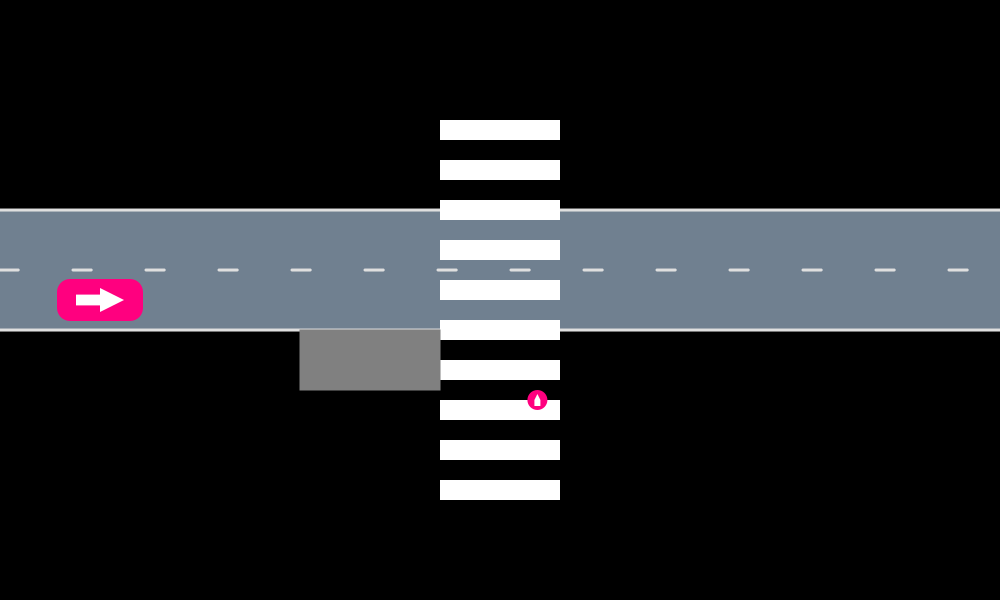

In [15]:
# Car definition
ego_initial_state = VehicleState(VecSE2(5.0, 0., 0.), env.roadway.segments[1].lanes[1],env.roadway, 8.0)
ego = Vehicle(ego_initial_state, VehicleDef(), 1)

scene = Scene()
push!(scene, ego)

ped = initial_pedestrian(env, config.rng)
push!(scene, ped)

# visualize the initial state
render(scene, env, cam=cam)

## Test with baseline policy

In [25]:
ego = initial_ego(env, config.rng)
policy = waitAndGo(env, ego, 2.0, -4.0, config.sim_dt, 4, 2.5, true, false, false, 0)
updater = waitAndGoUpdater(policy);

In [26]:
overlay = WaitAndGoOverlay(config.sim_dt, 0., policy)

WaitAndGoOverlay(0.1,0.0,waitAndGo(CrosswalkEnv(Roadway,AutomotiveDrivingModels.Lane(LaneTag(1, 1),AutomotiveDrivingModels.CurvePt[CurvePt({25.000, -10.000, 1.571}, 0.000, 0.000, NaN),CurvePt({25.000, 10.000, 1.571}, 20.000, 0.000, NaN)],6.0,AutomotiveDrivingModels.SpeedLimit(-Inf,Inf),AutomotiveDrivingModels.LaneBoundary(:unknown,:unknown),AutomotiveDrivingModels.LaneBoundary(:unknown,:unknown),AutomotiveDrivingModels.LaneConnection[],AutomotiveDrivingModels.LaneConnection[]),AutomotiveDrivingModels.ConvexPolygon[ConvexPolygon: len 4 (max 4 pts)
	VecE2(15.000, -1.500)
	VecE2(15.000, -4.500)
	VecE2(22.000, -4.500)
	VecE2(22.000, -1.500)
],EnvParams(2,50.0,3.0,20.0,6.0,5.0,37.0,8.0,0.5,2.0,10.0)),Vehicle(1, VehicleState(VecSE2({5.000, 0.000}, 0.000), Frenet(RoadIndex({1, 0.100000}, {1, 1}), 5.000, 0.000, 0.000), 7.048), VehicleDef(CAR, 4.000, 1.800)),2.0,-4.0,0.1,4,2.5,true,false,false,0),1,1,RGB{N0f8}(1.0,1.0,1.0),20)

In [27]:
function reset_policy!(policy::waitAndGo)
    policy.reaching = true
    policy.wait = false
    policy.go = false 
    policy.N = 0
end

reset_policy! (generic function with 1 method)

 overwritten at In[27]:2.


In [28]:
scene = Scene()
push!(scene, ego);

In [29]:
models = Dict{Int, DriverModel}()
# Constant speed model
models[1] = CrosswalkDriver(env, 0., Vehicle[], ego.state, sensor, policy, updater) 
models[2] = ConstantPedestrian(0.1, 0.5, 2.0, config.sim_dt)

ConstantPedestrian(0.1,0.5,2.0,0.1)

In [23]:
nticks = 200
rec = SceneRecord(nticks+1, config.sim_dt)
# execute the simulation
for i = 1:100
    reset_policy!(policy)    
    ego = initial_ego(env, config.rng)
    models[1] = CrosswalkDriver(env, 0., Vehicle[], ego.state, sensor, policy, updater) 
    scene = Scene()
    push!(scene, ego);
    @time simulate!(rec, scene, env, models, nticks, config.rng, config.callbacks)
    if !is_collision_free(rec[0])
        println("Crash")
        break
    end
end

  0.006631 seconds (26.75 k allocations: 1.627 MB)
Crash


In [30]:
reset_policy!(overlay.policy)
duration, fps, render_rec = animate_record(rec, overlay)
film = roll(render_rec, fps = fps, duration = duration)

Reel.Frames{MIME{Symbol("image/png")}}("C:\\Users\\Maxime\\AppData\\Local\\Temp\\jl_6934.tmp",0x0000000000000080,10.0,nothing)

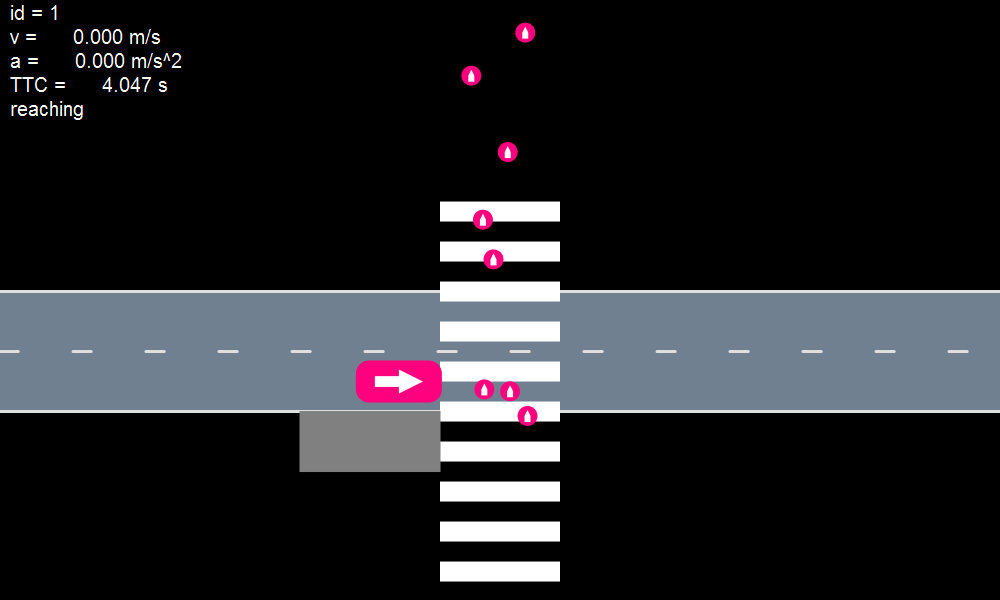

In [31]:
render(rec[-10], env, [overlay], cam=cam)

In [28]:
scene = rec.frames[1];
findfirst(scene, 1)

1

## Evaluate and tune the baseline

The parameters we wish to tune are the TTC threshold and the number of redundancy

In [29]:
function evaluate(th::Float64, N::Int64)
    # initialize policy to evaluate
    env.params.ped_rate = 0.2
    policy = waitAndGo(env, ego, 2.0, -4.0, config.sim_dt, N, th, true, false, false, 0);
    updater = waitAndGoUpdater(policy)

    models = Dict{Int, DriverModel}()
    # Constant speed model
    models[1] = CrosswalkDriver(env, 0., Vehicle[], ego.state, sensor, policy, updater) 

    #evaluation 
    config.n_episodes = 100
    nticks = config.time_out
    rec = SceneRecord(nticks+1, config.sim_dt)

    # intiialize containers and callbacks
    time_outs = 0
    crashes = 0
    successes = 0
    steps = zeros(config.n_episodes)


    for ep = 1:config.n_episodes

        # initialize scene
            reset_policy!(policy)    
    ego = initial_ego(env, config.rng)
    models[1] = CrosswalkDriver(env, 0., Vehicle[], ego.state, sensor, policy, updater) 
        scene = Scene()
        push!(scene, ego);


        simulate!(rec, scene, env, models, nticks, config.rng, config.callbacks)

        # analyze
        if rec.nframes == config.time_out + 1
            time_outs += 1
        elseif !is_collision_free(rec[0])
            crashes += 1
        elseif is_terminal(rec[0], env)
            successes += 1
        end

        steps[ep] = nframes(rec)       

    end
    try
        @assert time_outs + crashes + successes == config.n_episodes
    catch 
        println(time_outs, " ", crashes, " ", successes, " ", time_outs + crashes + successes)
    end
    return time_outs,crashes, successes,mean(steps)
end

evaluate (generic function with 1 method)

In [30]:
th_vec = 0:0.1:10
N_vec = 0:5
crashes = zeros(length(th_vec), length(N_vec))
successes = zeros(length(th_vec), length(N_vec))
time_outs = zeros(length(th_vec), length(N_vec))
steps = zeros(length(th_vec), length(N_vec))
for (i,th) in enumerate(th_vec)
    for (j,N) in enumerate(N_vec)
        time_outs[i,j], crashes[i,j], successes[i,j], steps[i,j] = evaluate(th, N)
    end
end

In [31]:
minimum(crashes)

21.0

In [32]:
maximum(successes)

69.0